In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from TrueDistributions import *

tf.experimental.numpy.experimental_enable_numpy_behavior()

mvn = MVN(tf.constant([0,0],dtype=tf.float32), tf.constant([[5,1],[0,1]],dtype=tf.float32))

def unnormalized_log_prob(x):
  return mvn.logPdf(x)

# Initialize the HMC transition kernel.
num_results = int(10e4)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[tf.cast([1,0], dtype=tf.float32)],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  # is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  
  return sample_mean, sample_stddev, is_accepted, samples

sample_mean, sample_stddev, is_accepted, samples = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))





mean:0.0051  stddev:1.7732  acceptance:[ True  True  True ...  True False False]


In [2]:
from itertools import chain
import tensorflow as tf
import tensorflow_probability as tfp
from TrueDistributions import *
from ChainMakers import *
tf.experimental.numpy.experimental_enable_numpy_behavior()

mvn = MVN(tf.constant([0,0],dtype=tf.float32), tf.constant([[5,1],[0,1]],dtype=tf.float32))

chain_maker = HamiltonianChainMaker(mvn,n=10**4,step_size=.2)

print(chain_maker)

mean:-0.0033  covariance:[[5.27124164 0.46319666]
 [0.46319666 1.27395152]]  acceptance rate:0.5283


In [5]:
chain_maker.getOutput()

array([[-1.3288407 , -0.04148383],
       [-0.3149916 , -0.15096769],
       [-2.9367518 , -0.27265632],
       [ 1.3250642 ,  0.05639231],
       [-1.9905299 , -0.14603016],
       [-1.5386124 , -0.31802154],
       [-1.4419053 , -0.04407716],
       [ 1.3071585 ,  0.03522158],
       [ 1.5530729 ,  0.32653108],
       [ 1.3738112 ,  0.05231094]], dtype=float32)

In [2]:
accepted_samples = samples[0][is_accepted]
accepted_samples

<tf.Tensor: shape=(64822, 2), dtype=float32, numpy=
array([[ 1.4902537 ,  0.92120695],
       [-1.2989757 ,  0.49741045],
       [ 1.8289638 ,  0.7245625 ],
       ...,
       [-1.2744658 , -1.051373  ],
       [ 2.466119  , -1.5070422 ],
       [-3.352931  , -0.8572254 ]], dtype=float32)>

In [3]:
np.cov(accepted_samples.numpy().T)

array([[5.38467702, 0.52803709],
       [0.52803709, 1.12108666]])

In [4]:

import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib.pyplot as plt

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Daniel Trager'), bitrate=1800)

#rc('animation', html='jshtml')
#rc('animation', embed_limit=100)

In [5]:
accepted_samples.numpy().T.shape

(2, 64822)

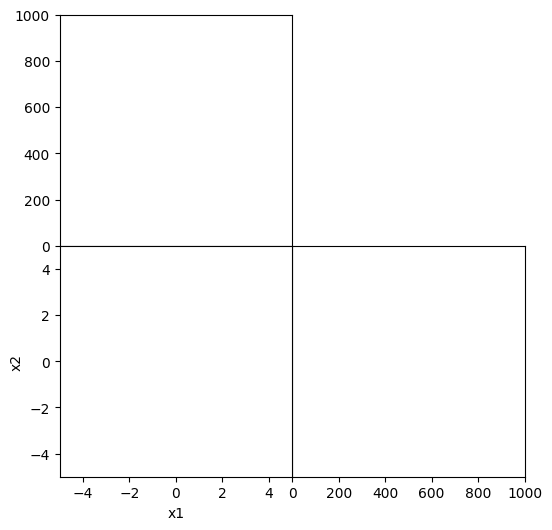

In [6]:
# Quickly hacked plotting code
samples = 1000

fig = plt.figure(figsize=(6, 6))
i_width = (-5, 5)
s_width = (-5, 5)
samples_width = (0, samples)
ax1 = fig.add_subplot(221, xlim=i_width, ylim=samples_width)
ax2 = fig.add_subplot(224, xlim=samples_width, ylim=s_width)
ax3 = fig.add_subplot(223, xlim=i_width, ylim=s_width,
                      xlabel='x1',
                      ylabel='x2')
fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
#path = plt.scatter([], [])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    # if i >= 200:
    #     i += 300
    current_samples = accepted_samples[:i+1].numpy().T
    line1.set_data(current_samples[0,:], range(i+1))
    line2.set_data(range(i+1), current_samples[1,:])
    line3.set_data(current_samples[0,:], current_samples[1,:])
    line4.set_data(current_samples[0,:], current_samples[1,:])
    curr_x, curr_y = current_samples[1,-1], current_samples[0,-1]
    line5.set_data([curr_y, curr_y], [curr_x, s_width[1]])
    line6.set_data([curr_y, i_width[1]], [curr_x, curr_x])
    return lines

In [7]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=samples, interval=5, blit=True)

anim.save('hmc.mp4', writer=writer)